<h1 style="text-align: center;">Deep Learning<br><br>Image Classification with CNN<br><br>Malaria Data<br><h1>


# Dataset Info

The dataset contains 2 folders - 'parasitized', 'uninfected'

And a total of 27,558 images.

This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/ 

# Import Libraries and Export Images from Zip_File

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# import warnings
# warnings.filterwarnings("ignore")
# warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10, 6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

np.set_printoptions(suppress=True) # avoid scientific number display

In [2]:
# check gpu connection
import tensorflow as tf

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# connect g-drive and this colab notebook
from google.colab import drive
drive.mount('/content/drive')
# google drive'ı colab'e bağlamak için bunu çalıştırıp izin ver

Mounted at /content/drive


In [11]:
# zipfile is a package used to work with zipped files
import zipfile # zip dosyalarıyla çalışmamızı sağlayan bir package

# Unzip the file
zip_ref = zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/cell_images.zip", "r" ) # drive'daki zipli dosyamızın uzantısını kopyalıp yapıştırıyoruz
zip_ref.extractall() # zipli dosyayı extract ediyor
zip_ref.close()      # işimiz bittiği için kapatıyoruz.


# Recognizing and Understanding Data

In [12]:
my_data_dir = "cell_images"    # datamın olduğu klasörün yolunu bir değişkene atıyorum.

# colabde drive'i her actigimizda tekrar baglanmak ve tum bunlari tekrar calistirmak lazim

In [13]:
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
os.listdir(my_data_dir) # os.listdir() to check and see the subfolders

# classlar hem train ve test altklasorlerinde parasited ve uninfected diye zaten ayri olarak hazirlanmis 
# target ve features icin. train test diye ayirmaya tekrar gerek yok

['test', 'train']

In [14]:
test_path = os.path.join(my_data_dir, 'test')     # cell_images/test     or  cell_images\test 
train_path = os.path.join(my_data_dir, 'train')   # cell_images/train    or  cell_images\test 
# commentlerdeki gibi bu sekilde de concat yapabilrdik, ama pathjoin isletim sistemimize gore ters veya duz slashi kendisi ayarliyor)

# os.path.join bizim işletim sistemize göre dosya yollarını belirliyor.

In [16]:
os.listdir(test_path)
# test_path icindeki klasorleri kontrol edelim
# os: operated system

['uninfected', 'parasitized']

In [17]:
# check train subfolders
os.listdir(train_path)

['uninfected', 'parasitized']

In [18]:
# assign class names to a variable
classes = os.listdir(train_path)
classes

# classes isimlerini bir değişkene atıyorum

['uninfected', 'parasitized']

In [19]:
# an alternative way to get the class names and to do all we have done above
import pathlib

data_dir = pathlib.Path(train_path)  # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # "*" bütün klasörler demek, herseyi getirir
# created a list of class_names from the subdirectories
# directoryde 100 class varsa biz sadece bazilarini getirmek istiyorsak * yerine regexle sinirlandirabilirz. ornegin 
# sadece a ile baslayan, sadece parazitle baslayann vs vs
print(class_names)

['parasitized' 'uninfected']


In [20]:
class_names

array(['parasitized', 'uninfected'], dtype='<U11')

**Let's check how many images there are.**

In [21]:
# control first 5 images in train-parasitized subdirectory
os.listdir(os.path.join(train_path, 'parasitized'))[:5]

['C70P31_ThinF_IMG_20150813_130510_cell_81.png',
 'C91P52ThinF_IMG_20150821_125154_cell_208.png',
 'C91P52ThinF_IMG_20150821_124504_cell_193.png',
 'C99P60ThinF_IMG_20150918_141129_cell_135.png',
 'C136P97ThinF_IMG_20151005_144449_cell_15.png']

In [22]:
# check the numbers of images in train path for both classes
len(os.listdir(os.path.join(train_path, 'parasitized'))), len(os.listdir(os.path.join(train_path, 'uninfected')))

(12479, 12479)

In [23]:
# # check the numbers of images in test path for both classes
len(os.listdir(os.path.join(test_path, 'parasitized'))), len(os.listdir(os.path.join(test_path, 'uninfected')))

(1300, 1300)

In [24]:
# Walk through cell_images directory and list number of files
# directory icine yukardaki gibi baktigimiz gibi bu sekilde, os.walk ile de bakabilriiz.

for dirpath, dirnames, filenames in os.walk(my_data_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'cell_images'.
There are 2 directories and 0 images in 'cell_images/test'.
There are 0 directories and 1300 images in 'cell_images/test/uninfected'.
There are 0 directories and 1300 images in 'cell_images/test/parasitized'.
There are 2 directories and 0 images in 'cell_images/train'.
There are 0 directories and 12479 images in 'cell_images/train/uninfected'.
There are 0 directories and 12479 images in 'cell_images/train/parasitized'.


**Let's take an example images from both train-parasitized and train-uninfected folders to observe process** 

In [25]:
# retrive first 10 images from train directory
os.listdir(os.path.join(train_path, 'parasitized'))[:10]

['C70P31_ThinF_IMG_20150813_130510_cell_81.png',
 'C91P52ThinF_IMG_20150821_125154_cell_208.png',
 'C91P52ThinF_IMG_20150821_124504_cell_193.png',
 'C99P60ThinF_IMG_20150918_141129_cell_135.png',
 'C136P97ThinF_IMG_20151005_144449_cell_15.png',
 'C60P21thinF_IMG_20150804_105034_cell_125.png',
 'C116P77ThinF_IMG_20150930_172112_cell_111.png',
 'C120P81ThinF_IMG_20151002_130150_cell_206.png',
 'C48P9thinF_IMG_20150721_163810_cell_9.png',
 'C59P20thinF_IMG_20150803_115303_cell_5.png']

In [26]:
# checkt the 5th among the first 10
os.listdir(os.path.join(train_path, 'parasitized'))[5]

'C60P21thinF_IMG_20150804_105034_cell_125.png'

In [27]:
# get the path of the 5th image and assignn it to a variable
para_cell_path = os.path.join(train_path, 'parasitized', os.listdir(os.path.join(train_path, 'parasitized'))[5]) # 5.resmin yolu(parasitized)

In [28]:
para_cell_path

'cell_images/train/parasitized/C60P21thinF_IMG_20150804_105034_cell_125.png'

In [29]:
imread(para_cell_path)
# we can't use imshow() directly here since the images are not in array format. 
# imread(): image read is from matplotlb library and converts the images in pmg format to array

# elimizdeki resimler png formatında biz bunları imread ile array'e çeviriyoruz.
# imread'i matplotlib içerisinden import ettik

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [30]:
para_cell = imread(para_cell_path)

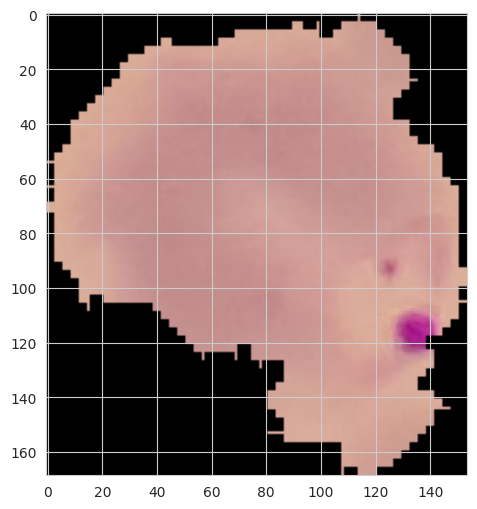

In [31]:
# now we can display the image with imshow after converting it via imread
plt.imshow(para_cell);
# imshow ile array formatındaki resmi artık okutabiliriz.

In [32]:
para_cell.shape
# 3. channels: colored image
# size 169x154

(169, 154, 3)

In [33]:
# do the same for an example from uninfected class
os.listdir(os.path.join(train_path, 'uninfected'))[:10]

['C97P58ThinF_IMG_20150917_145555_cell_88.png',
 'C209ThinF_IMG_20151029_160857_cell_126.png',
 'C183P144NThinF_IMG_20151201_223208_cell_89.png',
 'C5NThinF_IMG_20150609_122006_cell_3.png',
 'C101P62ThinF_IMG_20150918_151006_cell_17.png',
 'C91P52ThinF_IMG_20150821_123116_cell_102.png',
 'C48P9thinF_IMG_20150721_160944_cell_165.png',
 'C161P122ThinF_IMG_20151116_101403_cell_71.png',
 'C207ThinF_IMG_20151029_143952_cell_233.png',
 'C110P71ThinF_IMG_20150930_105319_cell_144.png']

In [34]:
uninfected_cell_path = os.path.join(train_path, 'uninfected/', os.listdir(os.path.join(train_path, 'uninfected'))[5]) # 5.resmin yolu(uninfected)

In [35]:
imread(uninfected_cell_path)

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

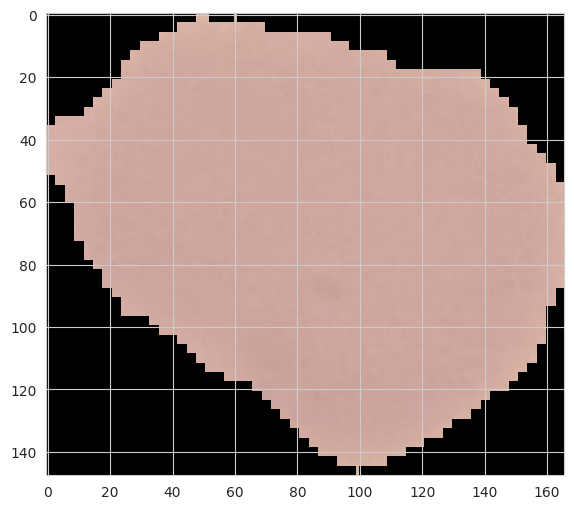

In [36]:
uninfected_cell = imread(uninfected_cell_path)
plt.imshow(uninfected_cell);

In [37]:
uninfected_cell.shape
# 148x166 a different size
# model kurarken ortak boyut gerekir, bu nedenle boyutlari aynilastirmamiz gerekir

(148, 166, 3)

In [38]:
# View a random image
# yukarda yaptigimiz islemleri bir function olarak tanimlayarak imagelari direkt getirelim
import random


def view_random_image(target_dir, target_class):
    """Returns a randomly selected image after displaying it,
    given directory path and class names.
    Args:
        target_dir (str): Relative path to the target directory
        target_class (str): The name of the target class to randomly select a picture from
    Returns:
        img (np.ndarray): Randomly selected image as np.ndarray
    """
    # Setup target directory (we'll view images from here)
    target_folder = os.path.join(target_dir, target_class)

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1) # a random sample

    # Read in the image and plot it using matplotlib
    img = imread(os.path.join(target_folder, random_image[0]))
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}")  # show the shape of the image

    return img

Image shape: (136, 133, 3)


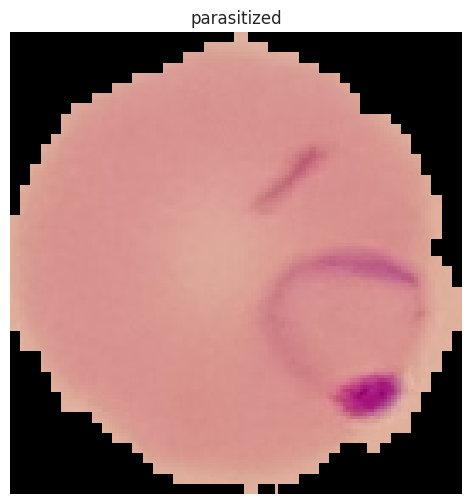

In [39]:
# View a random image from the training dataset
img = view_random_image(target_dir=train_path,
                        target_class="parasitized")

Image shape: (127, 130, 3)


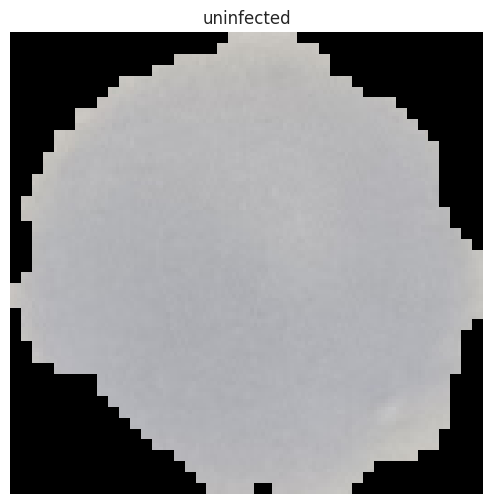

In [40]:
# View a random image from the training dataset
img = view_random_image(target_dir=train_path,
                        target_class="uninfected")

Image shape: (118, 136, 3)


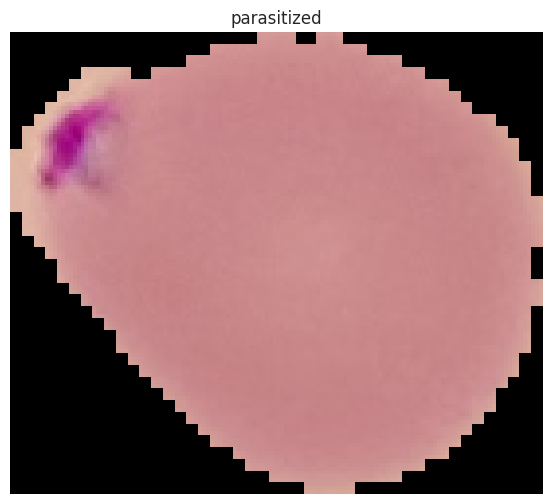

In [41]:
# View a random image from the training dataset
img = view_random_image(target_dir=train_path,
                        target_class=random.choice(class_names))  # class_names yukarıda tanımlamıştık.
  # class name'i de random seçmek için random.choice methodunu kullanıyoruz

# Data Preprocessing

## Defining Input Shape

**Let's decide on the final dimension of these images.**

In [42]:
uninfected_cell.shape

(148, 166, 3)

In [43]:
para_cell.shape

(169, 154, 3)

boyutlari aynilastirmak icin ilk yontem. Asagida list comp ile ikinci yontemi kullanalim zaman tasarrufu icin


```python
x = []
y = []

for image in os.listdir(train_path+'uninfected'):
    img = imread(train_path+'uninfected/'+image)
    d1,d2,_ = img.shape
    x.append(d1)
    y.append(d2)
```

In [44]:
x = [  imread(os.path.join(train_path, 'uninfected', image)).shape[0]
       for image in os.listdir(os.path.join(train_path, 'uninfected'))
       if 'Thumbs.db' not in image   ] # klasorlerin icinde shape'i alinamayacak istenmeyen dosyalar varsa onlari ayikla


y = [
      imread(os.path.join(train_path, 'uninfected', image)).shape[1]
      for image in os.listdir(os.path.join(train_path, 'uninfected'))
      if 'Thumbs.db' not in image
]

In [45]:
x[:5]
# x'in ilk 5inin boyutlar

[133, 115, 118, 112, 151]

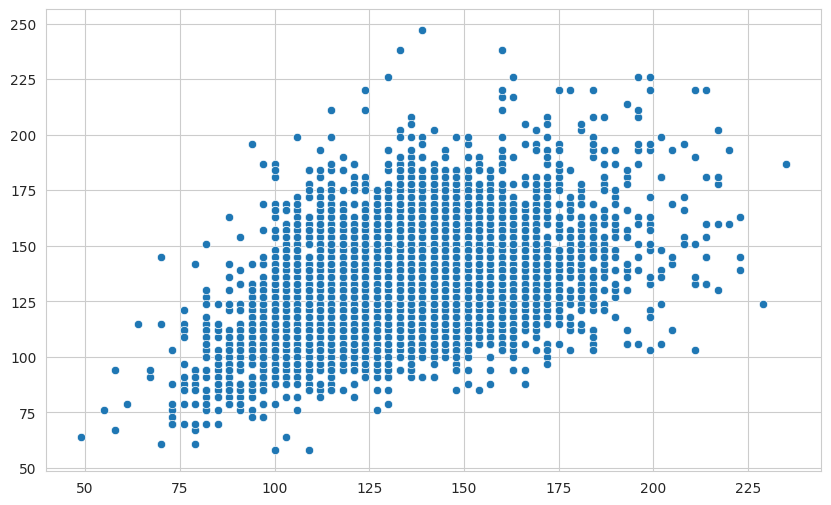

In [46]:
sns.scatterplot(x=x, y=y);
# tum fotolarin boyutlarini sctatterplotla gorelim
# orta moktasi 130x130 gibi; tamamini bu boyutta aynilastirabiliriz

In [47]:
np.mean(x), np.median(x)
# mean median ile kontrol edelim ort boyutlari

(131.64820899110507, 130.0)

In [48]:
np.mean(y), np.median(y)
# median veya mean degerleri cok yuksek cikabilir, yine de daha dusuk almakta fayda var.

(131.4041990544114, 130.0)

In [49]:
image_shape = (130, 130, 3)

# kullandığımız resimlerin boyutları çok büyük olursa overfite gidebiliyor modeller. Faltten yaptigimizda cok sayida feature olur cunku
# Burada dağılıma bakarak bir karar verdik. Ayrica 400x400 secsek ornegin bizi cok yavaslatirdi.
# ama başka bir boyut da seçebilirdik,dağılıma bize bir fikir vermesi adına bakıyoruz.Mesela 140,140,3'te seçebilirdik.
# Şu anda resimlerin boyutlarında bir çevirme işlemi daha yapmadık ! image_shape'i variable olarak belirledik, asagida kullanacagiz.

## Scaling

**Let's check the images if they are needed to be scaled or not**

In [50]:
uninfected_cell.max()

0.8627451

In [51]:
para_cell.max()

0.9137255

As we see above, all images have already been scaled

## Image Data Generator

**Image Manipulation**

We can use the ImageDataGenerator to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. ImageDataGenerator does the followings.

* Accepts a batch of images used for training.
* Applies a series of random transformations to each image in the batch.
* Replaces the original batch with randomly transformed batch.
* Training the CNN on this randomly transformed batch.

The goal of applying data augmentation is to have a more generalized model.

Data augmentation is a way to try and prevent a model overfitting. If your model is overfiting (e.g. the validation loss keeps increasing), you may want to try using data augmentation.

İm DATA GEn cnn algoritmalarinda overfittingi engellemenin bir yonudur. Ornegin trainde tamamen vesikaliklardan olusan bir data gercek hayattaki yuz fotolarina cevap veremeyecektir, farkli acilardan bozulmus fotolari taniyamayacaktir. IM D Gen image manipulation ile size, rotation vb degisikliklerle test datasina daha uygun cevap vermesini ve genelleme yapabilmesini saglar. Gercek fotolara biraz bias ekleyecegiz.

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [53]:
# help(ImageDataGenerator)

In [54]:
image_gen = ImageDataGenerator(rotation_range=15,             # resmi sağa veya sola max 15 dereceye kadar döndür
                               width_shift_range=0.10,        # resmin enini max %10 olacak şekilde kaydır
                               height_shift_range=0.10,       # resmin yüksekliğini max %10 olacak şekilde kaydır
                               # rescale=1/255,               # scale'e ihtiyaç varsa burada scale edebiliyoruz.
                               shear_range=0.1,               # resmin bir kısmını kırpmamızı sağlıyor max %10'nunu
                               zoom_range=0.1,                # zoom-in ya da zoom out da olabilir. max % 10'a kadar.
                               horizontal_flip=True,          # resme yatay eksende aynalama işlemi yap
                               fill_mode='nearest')           # kenarlarda oluşan boşlukları en yakındaki pikselle doldur.

                               # burda belirlediklerimiz sinirlar. model bu sinirlar icin rastgele sececek. ornegin ilk batchte rangei 5 shear 0.02
                               # ikinci batchte daha farkli degerlerle vs yapabilir.

**tensorflow.org ImageDataGenerator for all parameters and details to use ImageData Generator**

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [55]:
# scale'e gerek olmadigi icin scale'siz bos birakiyoruz.
val_image_gen = ImageDataGenerator()

# validation datasıyla sadece modelin performansına bakacağız ondan dolayı modeli eğitirken yukarıdaki gibi işlemlerden geçmesini istemiyoruz;
# bu nedenle val data IDG'u bos biraktik: (). Sadece scale'e ihtiyacımız varsa burada belirtebilirdik.

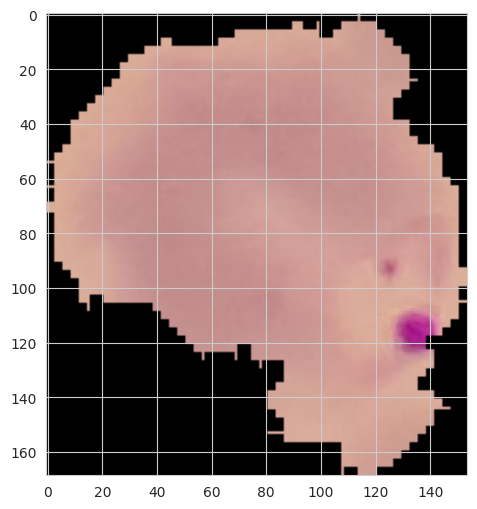

In [56]:
plt.imshow(para_cell);

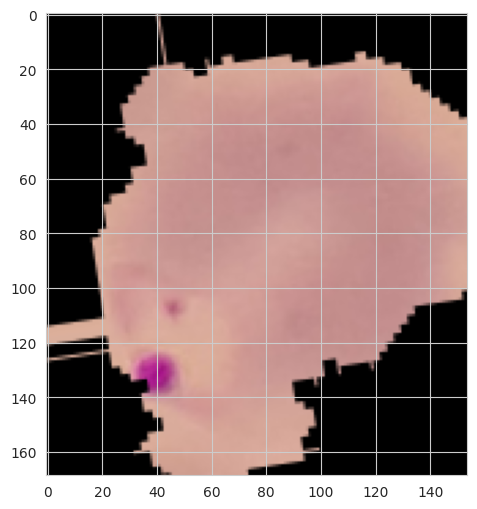

In [57]:
# check how IDG works. random_transform() is a method of IDG.
plt.imshow(image_gen.random_transform(para_cell));

# image_gen diye bir object oluşturduk yukarıda , random_transform methoduyla her çalıştırdığımızda farklı transformlar yaptığını görebiliyoruz yukarıda verdiğimiz talimatlar doğrultusunda.

### Taking the path to a directory & Generating batches of augmented data

flow_from_directory function works with images organized in sub-directories. Your directories should include only one class of images, so one folder per class of images.

In [58]:
# help(image_gen.flow_from_directory)
# Takes the path to a directory & generates batches of augmented data.

In [59]:
image_gen.flow_from_directory(train_path)
# flow_from_directory function works with images organized in sub-directories. 
# The directories should include only one class of images, so one folder per class of images.

Found 24958 images belonging to 2 classes.


In [60]:
val_image_gen.flow_from_directory(test_path)
# for test data, val_image_gen assigned above

Found 2600 images belonging to 2 classes.


In [61]:
# IMPORTANT: if we use IDG, then we should define batch size not in fit() but before model.fit()
batch_size = 32

# flow_from_directory kullanıyorsak batch_size'ı fit içerisinde değil dışarıda belirliyoruz.
# keras datasetlerinde hazır oluyor fotolar; disardan fotolarla calisinca gpu'yu yormamasi icin tamamini degil de 32li gruplar halinde
# almasinni istiyoruz.

In [62]:
image_shape

(130, 130, 3)

In [63]:
# for train
train_image_gen = image_gen.flow_from_directory(directory=train_path,          
                                                target_size=image_shape[:2],   # klasörlerden bu resimleri alırken (130,130)'a döndür. 3 rgb olarak asagida
                                                color_mode='rgb',              # channel'ı burada belirtiyoruz: 3 channels
                                                batch_size=batch_size,         # modele bu image'ları verirken 32'li batch'ler halinde vereceğini söylüyoruz.
                                                class_mode='binary',           # elimizdeki data binary olduğu için bu şekilde belirtiyoruz
                                                shuffle=True)                  # shuffle=True ----> modelim eğitilirken hep parasitized ya da hep uninfected gelmesin de karışık gelsin diye.

Found 24958 images belonging to 2 classes.


In [64]:
test_image_gen = val_image_gen.flow_from_directory(directory=test_path,         # val_image_gen'i kullanıyoruz burada !
                                                   target_size=image_shape[:2], # 130 ve 130u al ilk 2si. 3 icin asagida rgb
                                                   color_mode='rgb',
                                                   batch_size=batch_size,
                                                   class_mode='binary',
                                                   shuffle=False)  

# modelimin performansını ölçerken her epoch sonunda bir eğitim olmadığından karışık gelmesine gerek yok (shuffle=False). +
# shuffle=True yaparsak eğer test datasıyla (actual) predictionları karşılaştırmak istediğimizde sıra bozulacağından doğru bir karşılaiştırma yapamayız.

Found 2600 images belonging to 2 classes.


In [65]:
train_image_gen.class_indices
## train_image_gen class isimlerini öğrenmiş ve 0/1 atamasını yapmış

{'parasitized': 0, 'uninfected': 1}

In [66]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [67]:
# check train_image_gen. 
train_image_gen
# Iterator bir veri tipi

In [68]:
train_image_gen[0][0].shape

# resimleri batchler halinde şu anda hazırladı ve boyutlarını da bizim istediğimiz formata getirdi.Ama daha transform yapmadı !

(32, 130, 130, 3)

In [69]:
train_image_gen[0][0][0].shape

(130, 130, 3)

In [70]:
len(train_image_gen), len(test_image_gen)  # toplam batch sayısı trainde 780, testte 82

(780, 82)

In [71]:
len(train_image_gen) * batch_size, len(test_image_gen) * batch_size

# 82x32 = 2624

(24960, 2624)

In [72]:
# Get a sample of the training data batch
images, labels = train_image_gen.next()  # get the 'next' batch of images/labels
len(images), len(labels)      # 32 image , 32 label

(32, 32)

In [73]:
# Get a sample of the testing data batch
images, labels = test_image_gen.next()  # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

# Modelling-1

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [127]:
model1 = Sequential()

model1.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape, activation='relu'))   # input shape: 130x130 # kernel_size:filter_size
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))


model1.add(Flatten())


model1.add(Dense(128)) # or model1.add(Dense(128), activation= "relu")
model1.add(Activation('relu'))

model1.add(Dropout(0.5))

model1.add(Dense(1))
model1.add(Activation('sigmoid'))  # sigmoid for binary classification

# optimizer = keras.optimizers.Adam(lr=0.01)
model1.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

In [76]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [126]:
early_stop = EarlyStopping(monitor='val_loss',mode="min", patience=2, restore_best_weights=True)
# patience should be low bec it easily goes to overfitting in case of a higher patience
# restore_best_weights true to save the weights, bias, and filter coefs before early stopping

# patience 2 iken overfitting yoktu ama acc'ler 0.60 ve 0.62 idi, cok dusuk. bu nednele 4 patience ile asagida daha komplex bir model rebuild

In [128]:
model1.fit(train_image_gen,                           # içerisine train_image_gen verdiğimize dikkat edelim.(X_train,y_train degil). 
           epochs=10,
           steps_per_epoch=len(train_image_gen),      # her epochta 780 batch'imi de kullan diyorum.
           validation_data=test_image_gen,            # (X_test, y_test yerine test_image_gen)
           validation_steps=len(test_image_gen),      # her epoch sonunda tüm validation datamı kullan diyorum
           callbacks=[early_stop])

# resimleri transform işlemi biz fit dediğimiz zaman olmaya başladı.eğitim esnasında transform yapıldığı için daha uzun sürüyor epochlarımız.

# daha kisa surmesini istiyorsak yukarda batch sizei 256 vs olarak guncelleyebiliriz.

# bu kadar kotu skorlar oldugu icin patience'i 4 yapmaliyiz; local minimuma takilmis

Epoch 1/10
780/780 [==============================] - 139s 175ms/step - loss: 1.0180 - accuracy: 0.5563 - val_loss: 0.6664 - val_accuracy: 0.6088
Epoch 2/10
780/780 [==============================] - 141s 181ms/step - loss: 0.6746 - accuracy: 0.5849 - val_loss: 0.6553 - val_accuracy: 0.6138
Epoch 3/10
780/780 [==============================] - 167s 213ms/step - loss: 0.6678 - accuracy: 0.6015 - val_loss: 0.6567 - val_accuracy: 0.6192
Epoch 4/10
780/780 [==============================] - 127s 163ms/step - loss: 0.6620 - accuracy: 0.6119 - val_loss: 0.7048 - val_accuracy: 0.5877


In [129]:
model1.metrics_names

['loss', 'accuracy']

In [130]:
summary = pd.DataFrame(model1.history.history)
summary.head()

,loss,accuracy,val_loss,val_accuracy
0,1.018,0.556,0.666,0.609
1,0.675,0.585,0.655,0.614
2,0.668,0.602,0.657,0.619
3,0.662,0.612,0.705,0.588


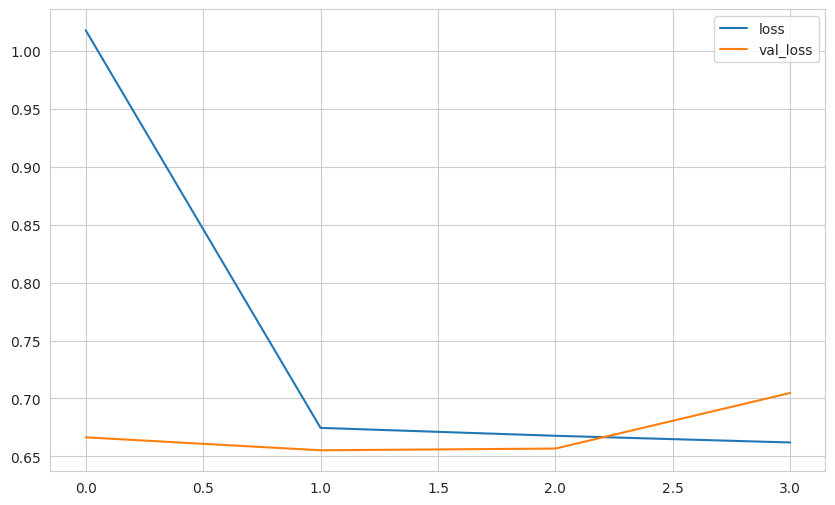

In [131]:
summary[["loss", "val_loss"]].plot();

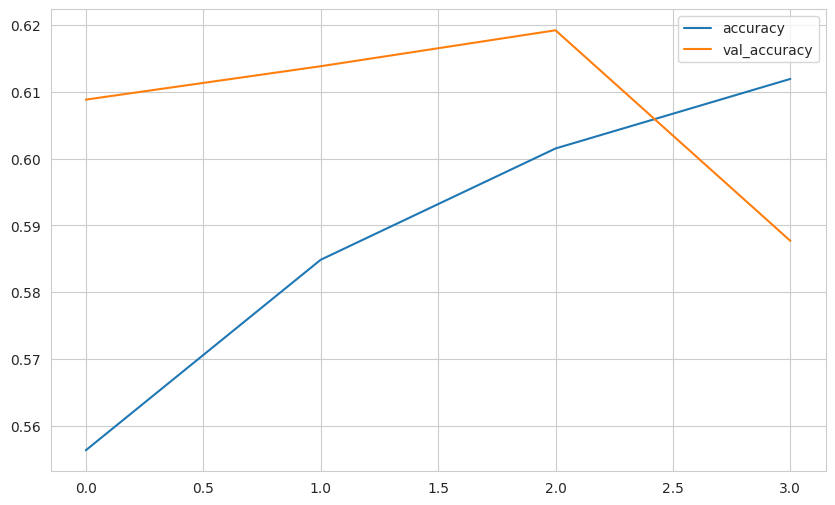

In [132]:
summary[["accuracy", "val_accuracy"]].plot();

# Evaluation on Test Data

In [83]:
from sklearn.metrics import classification_report, confusion_matrix

In [133]:
score = model1.evaluate(test_image_gen)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

82/82 [==============================] - 3s 35ms/step - loss: 0.6553 - accuracy: 0.6138
Test loss: 0.6552656292915344
Test accuracy: 0.6138461828231812


In [134]:
pred_prob = model1.predict(test_image_gen)  # test_image_gen 

82/82 [==============================] - 4s 47ms/step


In [135]:
pred_prob

array([[0.09711636],
       [0.3215647 ],
       [0.3464302 ],
       ...,
       [0.47426227],
       [0.27772793],
       [0.47248584]], dtype=float32)

In [136]:
y_pred = pred_prob > 0.5

In [137]:
y_pred

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [138]:
y_test = test_image_gen.classes
y_test

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [139]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.62      0.62      1300
           1       0.62      0.61      0.61      1300

    accuracy                           0.61      2600
   macro avg       0.61      0.61      0.61      2600
weighted avg       0.61      0.61      0.61      2600



In [140]:
confusion_matrix(y_test, y_pred)

array([[805, 495],
       [509, 791]])

# Modelling-2

In [92]:
model2 = Sequential()

model2.add(Conv2D(filters=64,
                  kernel_size=(3, 3),
                  input_shape=image_shape,
                  padding='same', # cok fazla conv layer ekleyecegiz, bu nedenle boyut kaybi olacaktir, onlemek icin padding same
                  activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=128,
                  kernel_size=(3, 3),
                  padding='same',
                  activation='relu'))
model2.add(Conv2D(filters=128,
                  kernel_size=(3, 3),
                  padding='same',
                  activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=256,
                  kernel_size=(3, 3),
                  padding='same',
                  activation='relu'))
model2.add(Conv2D(filters=256,
                  kernel_size=(3, 3),
                  padding='same',
                  activation='relu'))
model2.add(Conv2D(filters=256,
                  kernel_size=(3, 3),
                  padding='same',
                  activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=128, kernel_size=(3, 3),
                  padding='same',
                  activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=64,
                  kernel_size=(3, 3),
                  padding='same',
                  activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Flatten())


model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))

model2.add(Dense(1))
model2.add(Activation('sigmoid'))

model2.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

# overfitting olursa batchnormalization da kullanarak yenidne build edebiliriz

In [93]:
model2.summary()
# parametre sayisi 2m ustune cikti model karmasiklasinca


# flattendan hemen once filter 4e4 olmus, bu 1e1 olacak sekilde duserse hata verir ve durur.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 130, 130, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 65, 65, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 65, 65, 128)       73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 65, 65, 128)       147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 256)      

In [94]:
early_stop = EarlyStopping(monitor='val_loss', mode="min",patience=4, restore_best_weights=True)

In [95]:
model2.fit(train_image_gen,
           epochs=15,
           steps_per_epoch=len(train_image_gen),
           validation_data=test_image_gen,
           validation_steps=len(test_image_gen),
           callbacks=[early_stop])

Epoch 1/15
780/780 [==============================] - 150s 183ms/step - loss: 0.3136 - accuracy: 0.8889 - val_loss: 0.1674 - val_accuracy: 0.9477
Epoch 2/15
780/780 [==============================] - 140s 180ms/step - loss: 0.1723 - accuracy: 0.9484 - val_loss: 0.1641 - val_accuracy: 0.9446
Epoch 3/15
780/780 [==============================] - 140s 179ms/step - loss: 0.1633 - accuracy: 0.9514 - val_loss: 0.1627 - val_accuracy: 0.9531
Epoch 4/15
780/780 [==============================] - 140s 179ms/step - loss: 0.1651 - accuracy: 0.9506 - val_loss: 0.1529 - val_accuracy: 0.9531
Epoch 5/15
780/780 [==============================] - 142s 182ms/step - loss: 0.1587 - accuracy: 0.9518 - val_loss: 0.1558 - val_accuracy: 0.9542
Epoch 6/15
780/780 [==============================] - 141s 180ms/step - loss: 0.1502 - accuracy: 0.9537 - val_loss: 0.1371 - val_accuracy: 0.9538
Epoch 7/15
780/780 [==============================] - 142s 183ms/step - loss: 0.1526 - accuracy: 0.9530 - val_loss: 0.1492 -

In [96]:
model2.metrics_names

['loss', 'accuracy']

In [97]:
summary = pd.DataFrame(model2.history.history)
summary.head()

,loss,accuracy,val_loss,val_accuracy
0,0.314,0.889,0.167,0.948
1,0.172,0.948,0.164,0.945
2,0.163,0.951,0.163,0.953
3,0.165,0.951,0.153,0.953
4,0.159,0.952,0.156,0.954


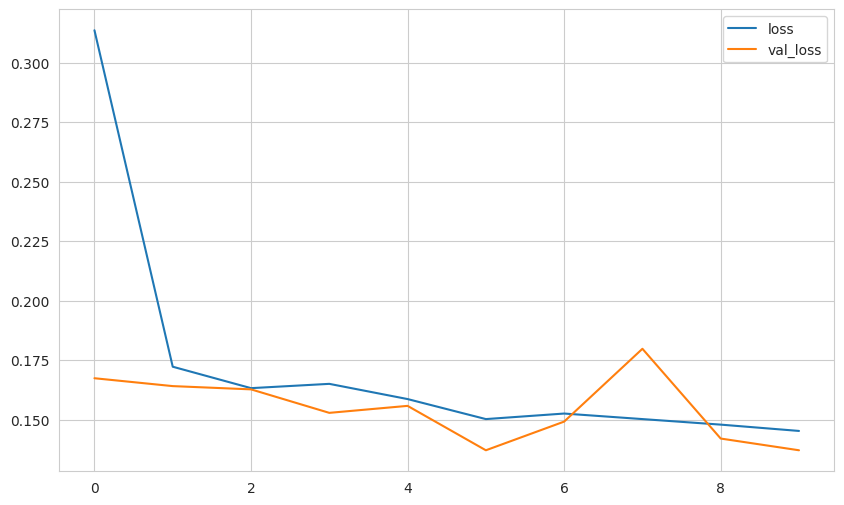

In [98]:
summary[["loss", "val_loss"]].plot()
plt.show()

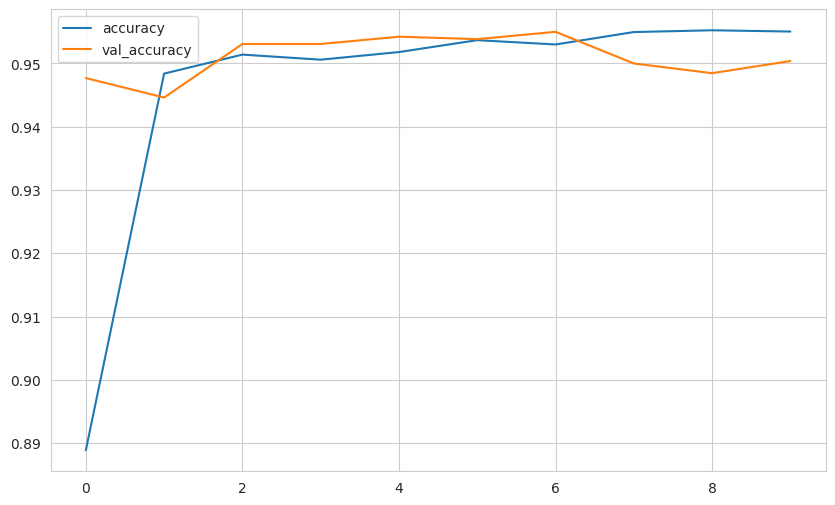

In [99]:
summary[["accuracy", "val_accuracy"]].plot()
plt.show()

# Evaluation on Test Data

In [100]:
score = model2.evaluate(test_image_gen)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

82/82 [==============================] - 4s 49ms/step - loss: 0.1371 - accuracy: 0.9538
Test loss: 0.13714149594306946
Test accuracy: 0.9538461565971375


In [101]:
pred_prob = model2.predict(test_image_gen)

82/82 [==============================] - 6s 70ms/step


In [102]:
y_pred = pred_prob > 0.5

In [103]:
print(classification_report(y_test, y_pred))   # y_test yukarıda oluşturmuştuk zaten

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1300
           1       0.95      0.96      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [104]:
confusion_matrix(y_test, y_pred)

array([[1237,   63],
       [  57, 1243]])

In [105]:
model2.save('malaria_model.h5')

# Prediction

In [106]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image  # disardan bir image geldiginde okuyabilmemizi saglayan librarilerden birisi

In [107]:
model = load_model('malaria_model.h5')

In [108]:
target_class = random.choice(class_names)
target_class

'uninfected'

In [109]:
# target classin test pathinden yolunu olusturuyoruz
random_image = random.sample(
    os.listdir(os.path.join(test_path, target_class)),
    1)
random_image

['C168P129ThinF_IMG_20151118_155802_cell_121.png']

In [110]:
# display icin pathini olusturalim
image_path = os.path.join(test_path, target_class, random_image[0])
image_path

'cell_images/test/uninfected/C168P129ThinF_IMG_20151118_155802_cell_121.png'

In [111]:
# boyut aynilastirma
# burada image.load_img(), yani import ettigimiz image kullaniyoruz
my_image = image.load_img(image_path, target_size=image_shape)   # resmi çağırırken image_shape ile modelimin eğitldiği boyuta getiriyorum.

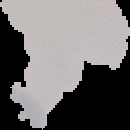

In [112]:
my_image

In [113]:
type(my_image)
# farkli typeoldugu icin arraye dosnuturmelyiz

PIL.Image.Image

In [114]:
# my_image = np.array(my_image)
my_image = image.img_to_array(my_image)  # image libraryninn image_to_array() ile array'e çeviriyoruz 

In [115]:
my_image.shape

(130, 130, 3)

In [116]:
my_image = np.expand_dims(my_image, axis=0)   # modelimi batchler halinde eğittiğimden kaç tane fotoğrafı tahmin edeceğini belirtmemiz gerekiyor.
# reshape ile de yapabiliriz bu dimension ayarlamayi

In [117]:
my_image.shape

(1, 130, 130, 3)

In [118]:
model.predict(my_image)
# yuzde 48 probability ile 1 classi.

1/1 [==============================] - 0s 179ms/step


array([[0.48294318]], dtype=float32)

In [119]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [120]:
# bu prediction asamasinda yaptigimiz herseyi bir user-defined function haline getirelim

def pred_and_plot(model, img_size):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    target_class = random.choice(class_names)
    random_image = random.sample(
        os.listdir(os.path.join(test_path, target_class)),
        1)
    img_path = os.path.join(test_path, target_class, random_image[0])
    img = image.load_img(img_path, target_size=img_size)
    img = np.array(img)

    # Make a prediction
    pred = model.predict(np.expand_dims(img, axis=0))
    print("prediction_probability: ", pred.max())   

    # Get the predicted class
    if len(pred[0]) > 1:  # check for multi-class
        pred_class = class_names[pred.argmax()]  # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])]  # if only one output, round

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

1/1 [==============================] - 0s 74ms/step
prediction_probability:  0.27925748


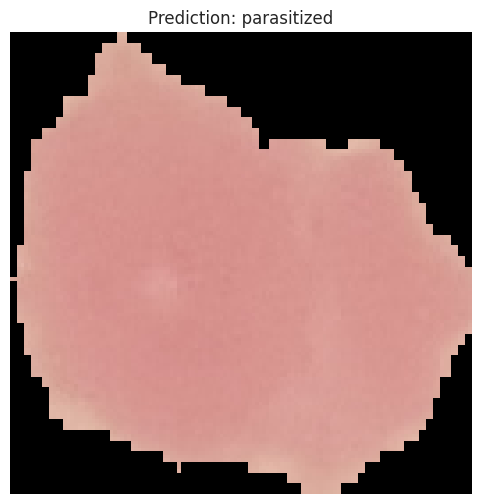

In [121]:
pred_and_plot(model, (130, 130))

Classlar imbalanced olsaydi:

- ilk once claslarin skorlarini karsilastirir ve ogrenip ogrenemedigine bakardik modelin
- az olan classi ogrenemeseydi class weight ile oynardik. az olan claasa agirlik verirdik 
- optunayi kotu skorlu classin recallunu max edecek sekilde ayarlayabiliriz
- bir ücüncü yol : y_pred = pred_prob > 50 yerine 0.35 yapabiliriz ornegin.
- Ama bunlari yaparken recall ve precision dengesini de dikkate almak gerekir. Datanin hassasiyetine göre kullanacagimiz metric ve/veya yöntem de değisecektir.
- Cnn ve Ann'deki yontemler ayni